In [1]:
%matplotlib inline

import pickle

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import gridspec

sns.set_context("poster")
sns.set_style("white")
mpl.rcParams["text.usetex"] = True
mpl.rcParams["font.family"] = "serif"
mpl.rcParams["font.serif"] = ["Computer Modern"]

# Setup

In [2]:
opt_titles = [
    ("dna", "DNA"),
    ("adam", "Adam"),
    ("adamax", "Adamax"),
    ("sgdnesterov", "SGD Nesterov"),
    ("rmsprop", "RMSprop"),
    ("sgd", "SGD"),
    ("adagrad", "Adagrad"),
    ("adadelta", "Adadelta")
]
colors = sns.xkcd_palette(["amber", "red", "greyish", "windows blue", "faded green", "dusty purple", "black", "light blue"])

In [3]:
def plot_losses(model, dataset, ax, loss_ylim=None):
    min_min_loss, min_max_loss = np.inf, np.inf
    for i, (opt, title) in enumerate(opt_titles):
        try:
            with open("../data/{}/{}/{}.pkl".format(model, dataset, opt), "rb") as f:
                data = pickle.load(f)
        except FileNotFoundError:
            continue
        loss_history = data["best_loss_history"]

        if .95*np.min(loss_history) < min_min_loss:
            min_min_loss = .95*np.min(loss_history)
        if .95*np.max(loss_history) < min_max_loss:
            min_max_loss = .95*np.max(loss_history)

        lr_str = "$\\alpha\\ 10^{{{}}}$".format(int(np.round(np.log10(data["best_opt_config"]["lr"]))))
        try:
            decay = data["best_decay"]
            if np.isclose(decay, 0):
                decay_str = ", $\\gamma\\ 0$"
            else:
                decay_str = ", $\\gamma\\ 10^{{{}}}$".format(int(np.round(np.log10(decay))))
        except KeyError:
            decay_str = ""
        ax.semilogy(range(1, len(loss_history) + 1), loss_history, label="{} ({}{})".format(title, lr_str, decay_str), color=colors[i], linewidth=3)

    ax.set_xlabel("Epoch")
    ax.set_ylabel("Loss")
    if loss_ylim is not None:
        ax.set_ylim(*loss_ylim)
        ax.set_yticks(np.logspace(np.log10(loss_ylim[0]), np.log10(loss_ylim[1]), 5))
    else:
        ax.set_ylim(min_min_loss, min_max_loss)
        ax.set_yticks(np.logspace(np.log10(min_min_loss), np.log10(min_max_loss), 5))
    ax_sexy_yticks = []
    for tick in ax.get_yticks():
        base, exp = "{:.1e}".format(tick).split("e")
        ax_sexy_yticks.append("${:.1f}\\times 10^{{{}}}$".format(float(base), int(exp)))
    ax.set_yticklabels(ax_sexy_yticks)
    ax.legend()

# CNN CIFAR10

## Loss History

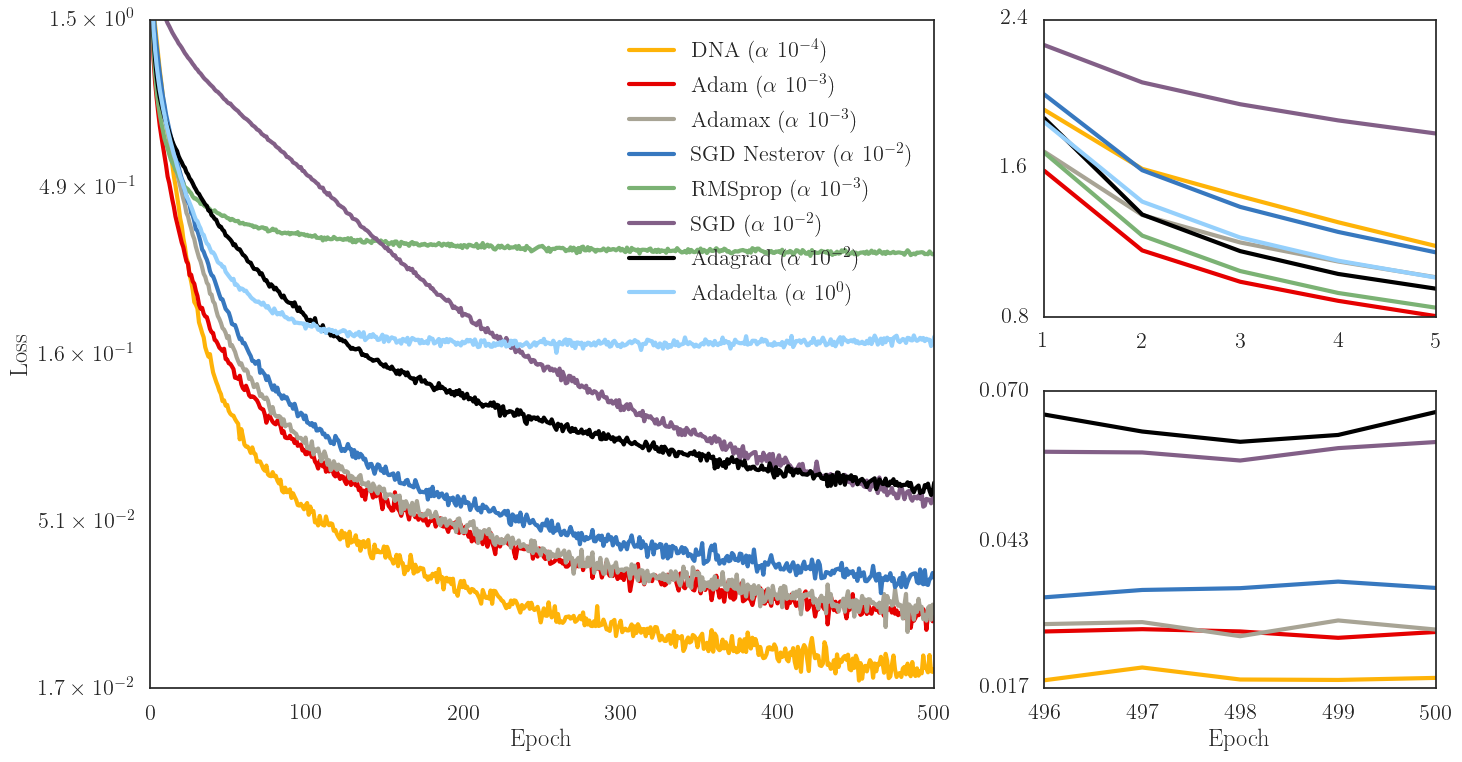

In [4]:
fig = plt.figure(figsize=(15, 8))
gs = gridspec.GridSpec(2, 2, width_ratios=[2, 1])
ax1 = fig.add_subplot(gs[:, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[1, 1])

plot_losses("cnn", "cifar10", ax1)

for i, (opt, title) in enumerate(opt_titles):
    with open("../data/cnn/cifar10/{}.pkl".format(opt), "rb") as f:
        loss_history = pickle.load(f)["best_loss_history"]
    ax2.plot(range(1, 6), loss_history[:5], color=colors[i], linewidth=3)
    ax3.plot(range(496, 501), loss_history[-5:], color=colors[i], linewidth=3)

ax2.set_ylim(0.8, 2.4)
ax2.set_yticks([0.8, 1.6, 2.4])
ax2.set_xticks(range(1, 6))

ax3.set_ylim(0.017, 0.07)
ax3.set_yticks([0.017, 0.043, 0.07])
ax3.set_xticks(range(496, 501))
ax3.set_xlabel("Epoch")

fig.tight_layout()

## $d$ History

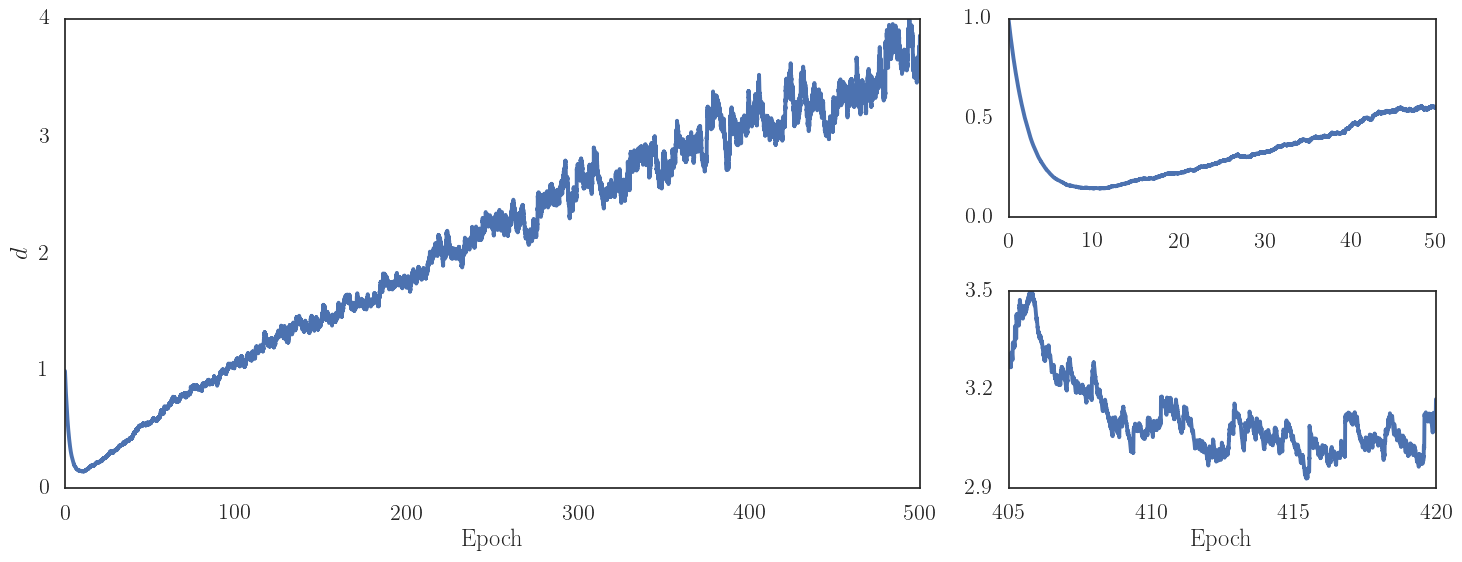

In [5]:
fig = plt.figure(figsize=(15, 6))
gs = gridspec.GridSpec(2, 2, width_ratios=[2, 1])
ax1 = fig.add_subplot(gs[:, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[1, 1])

with open("../data/cnn/cifar10/dna.pkl", "rb") as f:
    dna_ds = np.array([x.item() for x in pickle.load(f)["ds"]])
epoch_nums = np.arange(1, len(dna_ds) + 1) * 128. / 50000

ax1.plot(epoch_nums, dna_ds)
ax1.set_xlim(0, 500)
ax1.set_ylim(0, 4)
ax1.set_yticks([0, 1, 2, 3, 4])
ax1.set_xlabel("Epoch")
ax1.set_ylabel("$d$")

ax2.plot(epoch_nums[epoch_nums <= 50], dna_ds[epoch_nums <= 50])
ax2.set_xlim(0, 50)
ax2.set_ylim(0, 1)
ax2.set_yticks([0, 0.5, 1.0])

ax3_epoch_range = np.bitwise_and(epoch_nums >= 405, epoch_nums <= 420)
ax3.plot(epoch_nums[ax3_epoch_range], dna_ds[ax3_epoch_range])
ax3.set_xlim(405, 420)
ax3.set_ylim([2.9, 3.5])
ax3.set_xticks([405, 410, 415, 420])
ax3.set_yticks([2.9, 3.2, 3.5])
ax3.set_xlabel("Epoch")

fig.tight_layout()

# Generic Visual Experiments

## Visualization Code

In [6]:
def generic_visexp_visualize(model, dataset, loss_ylim=None):
    fig = plt.figure(figsize=(15, 6))
    gs = gridspec.GridSpec(2, 2, width_ratios=[2, 1])
    ax1 = fig.add_subplot(gs[:, 0])
    ax2 = fig.add_subplot(gs[0, 1])
    ax3 = fig.add_subplot(gs[1, 1])

    plot_losses(model, dataset, ax1, loss_ylim)

    with open("../data/{}/{}/dna.pkl".format(model, dataset), "rb") as f:
        dna_data = pickle.load(f)
    ds = np.array([x.item() for x in dna_data["ds"]])
    eff_ds = ds * (1. + (dna_data["best_opt_config"]["decay"] * np.arange(1, len(ds) + 1)))
    
    ax2.semilogx(ds)
    ds_lims = [.9*np.min(ds), 1.1*np.max(ds)]
    ax2.set_ylim(*ds_lims)
    ax2.set_yticks(np.linspace(ds_lims[0], ds_lims[1], 3))
    ax2_pretty_yticks = []
    for tick in ax2.get_yticks():
        ax2_pretty_yticks.append("{:.1f}".format(tick))
    ax2.set_yticklabels(ax2_pretty_yticks)
    ax2.set_xticks([])
    ax2.set_ylabel("$d_t$")

    ax3.loglog(eff_ds)
    ax3.set_xlabel("$t$")
    ax3.set_ylabel("$d_t(1 + \\gamma t)$")

    fig.tight_layout()

## Logistic MNIST

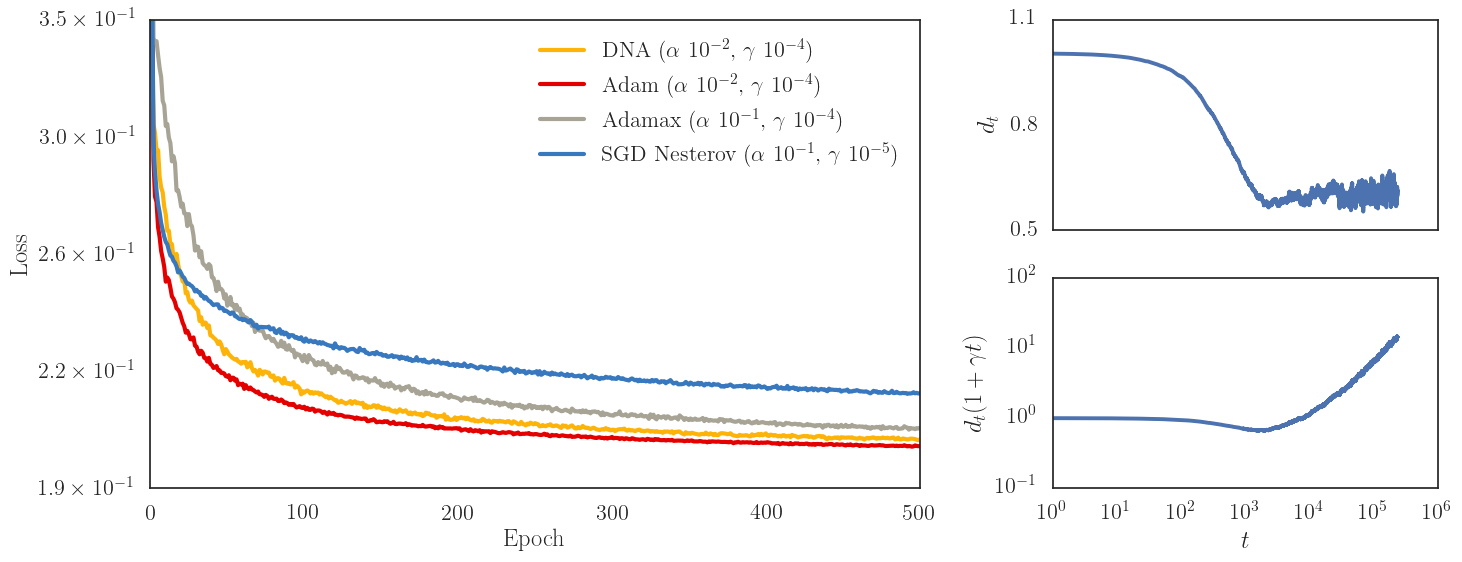

In [7]:
generic_visexp_visualize("logistic", "mnist")

## Logistic CIFAR10

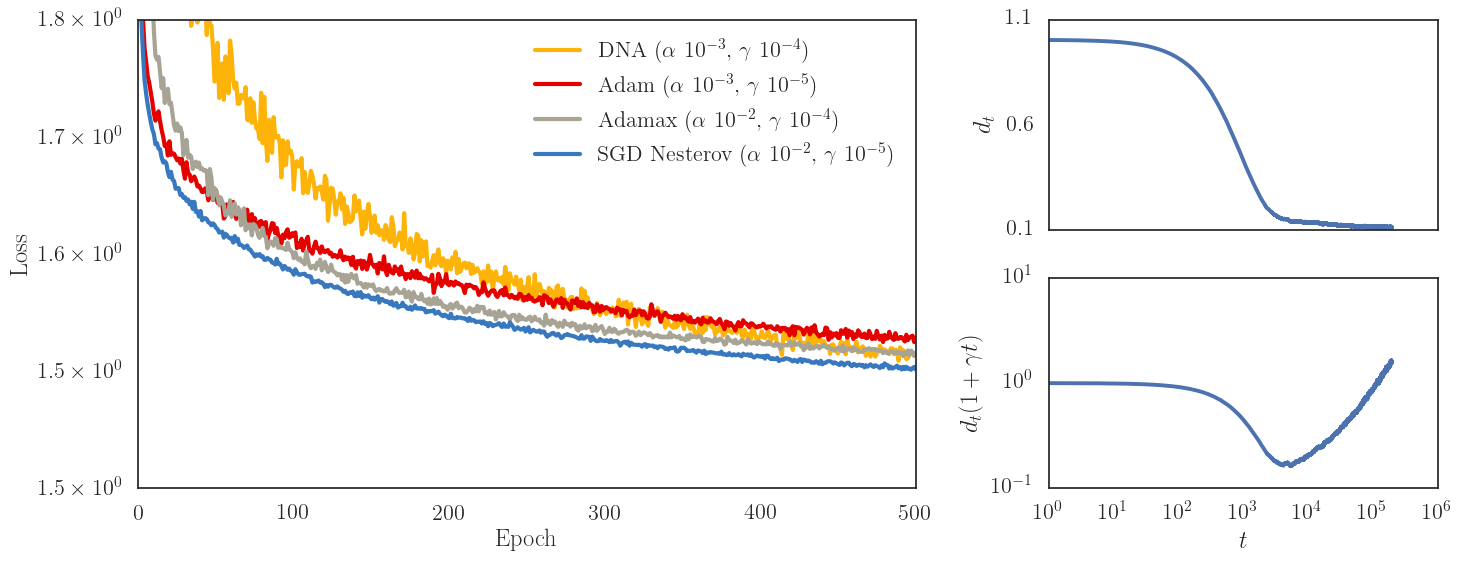

In [8]:
generic_visexp_visualize("logistic", "cifar10")

## Logistic CIFAR100

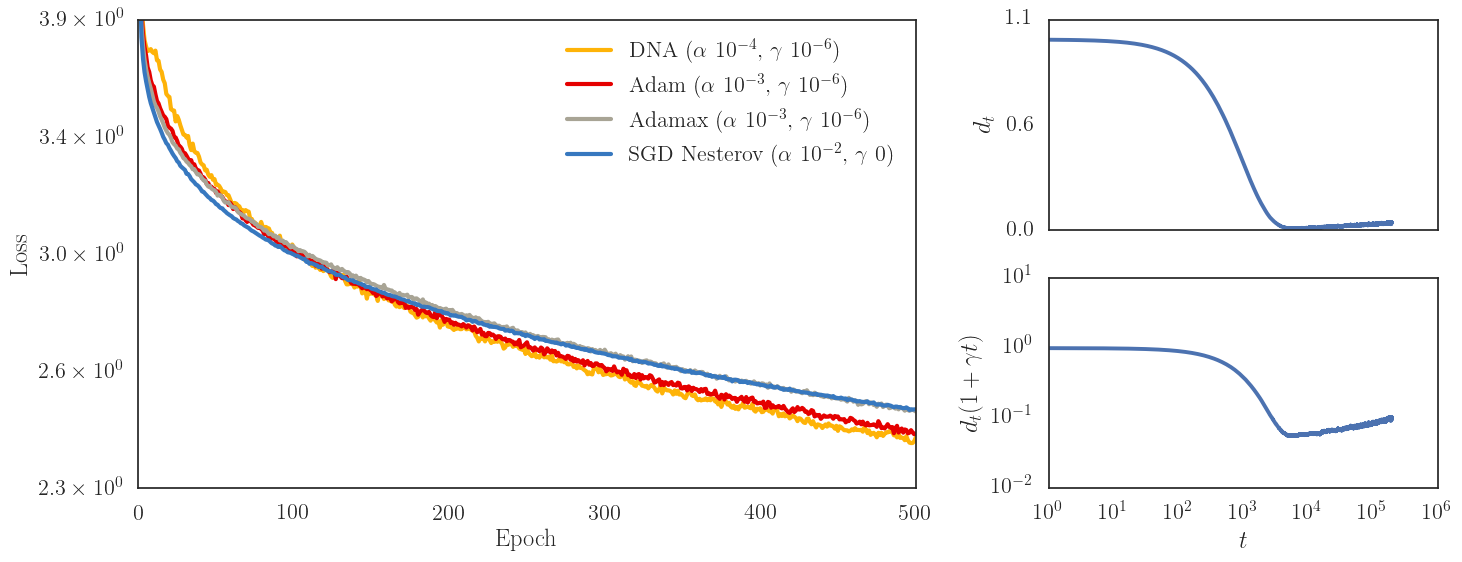

In [9]:
generic_visexp_visualize("logistic", "cifar100")

## MLNN MNIST

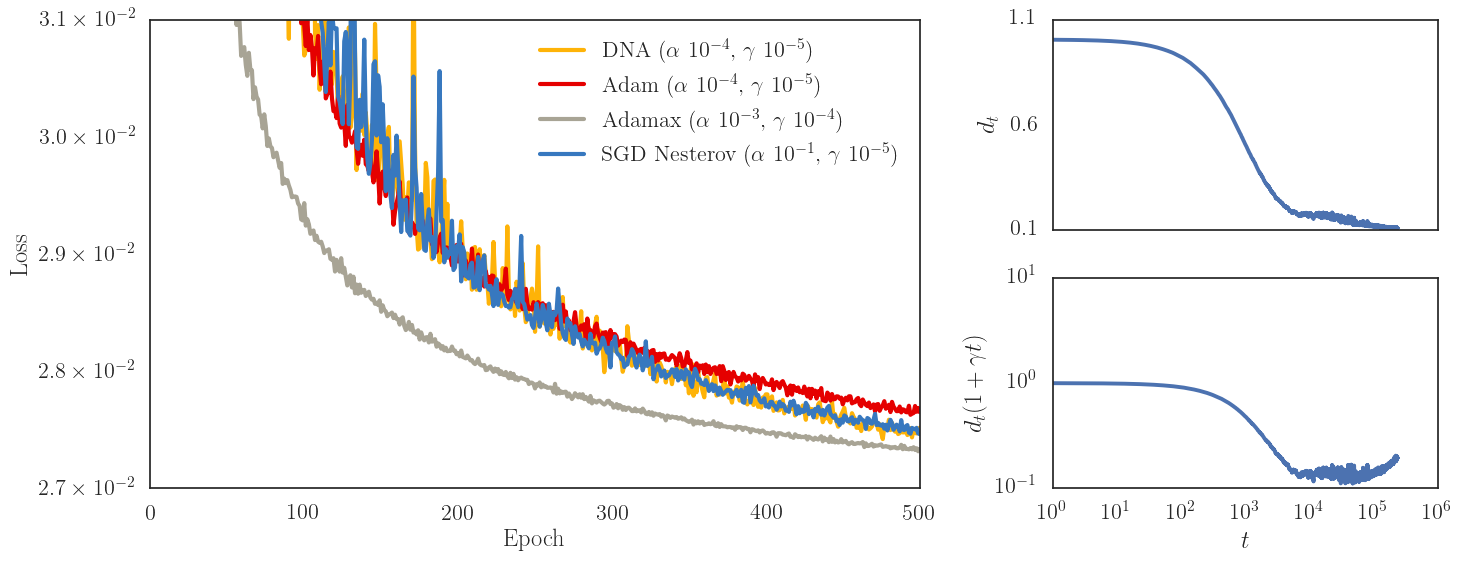

In [10]:
generic_visexp_visualize("mlnn", "mnist", (.027, .031))

## MLNN CIFAR10

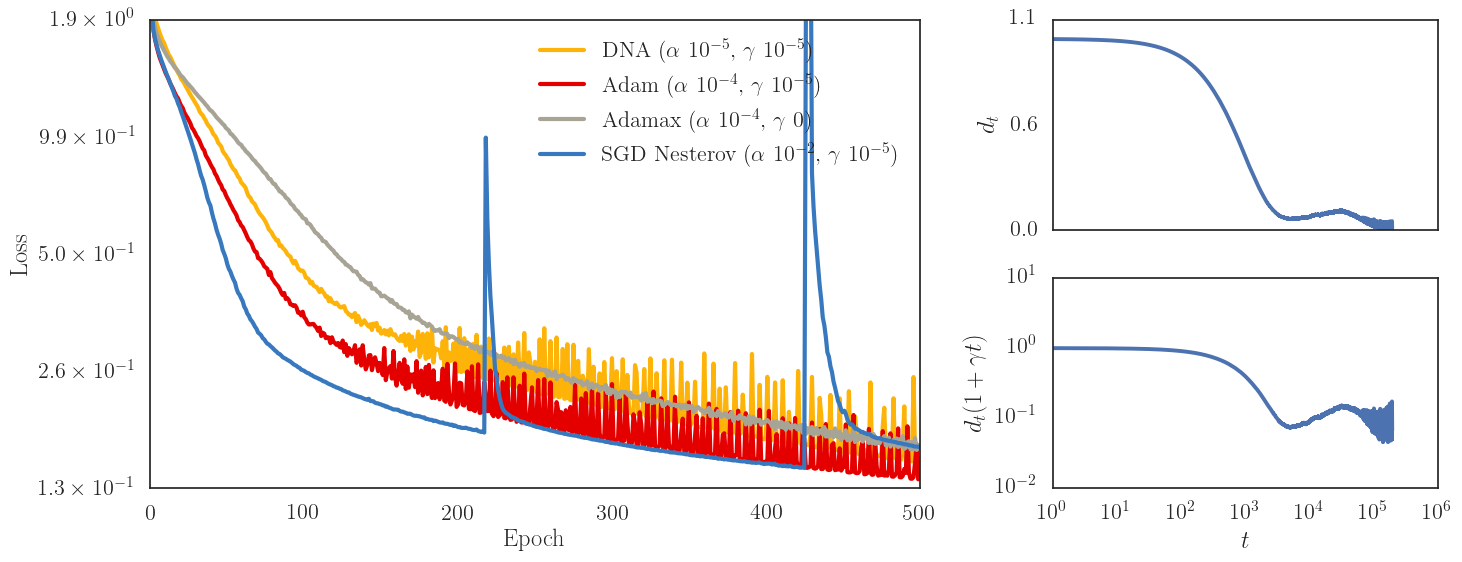

In [11]:
generic_visexp_visualize("mlnn", "cifar10")

## Big CNN CIFAR100

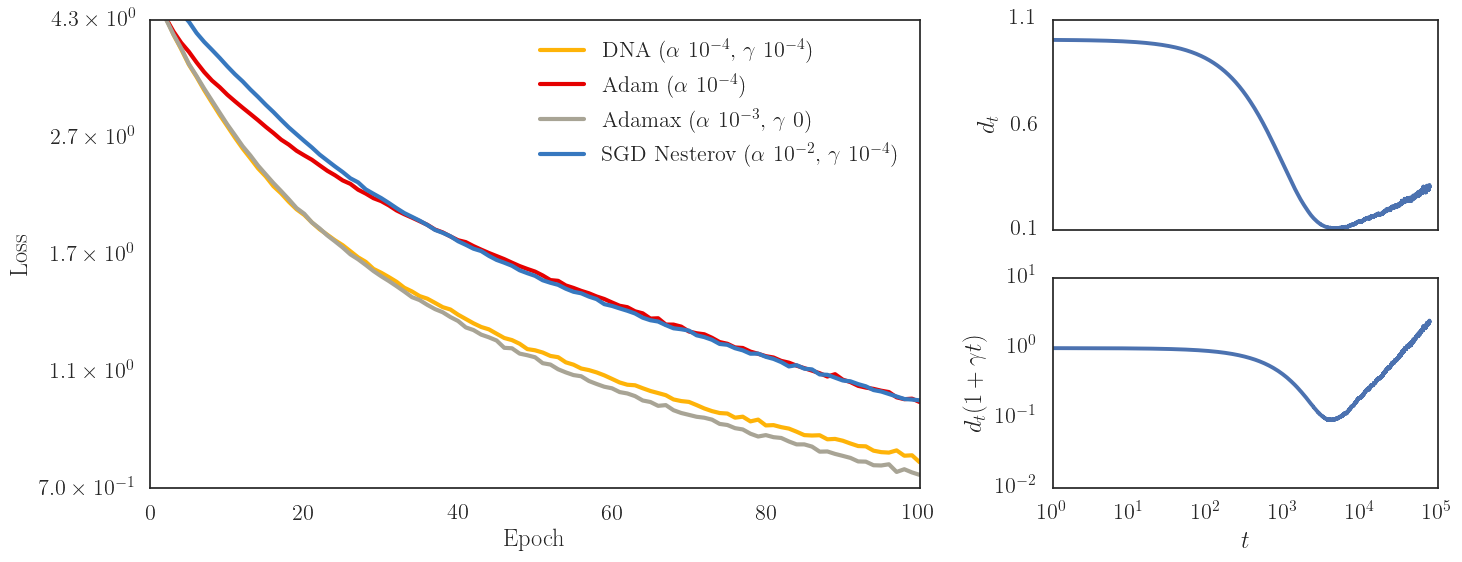

In [12]:
generic_visexp_visualize("big_cnn", "cifar100")